# Installs and imports

In [3]:
%%capture
!pip uninstall -y numpy grakel
!pip install grakel
!pip install graphein
!pip install numpy==1.23.5
!pip install botorch
!pip install gauche

!pip install mordred

MUST RESTART RUNTUIME!!!

In [168]:
import botorch
botorch.__version__


'0.13.0'

In [169]:

# Imports

import warnings
warnings.filterwarnings("ignore") # Turn off Graphein warnings

import time



import numpy as np
from botorch.fit import fit_gpytorch_mll
import gpytorch
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch

from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data


from gauche import SIGP, NonTensorialInputs
from gauche.kernels.fingerprint_kernels.tanimoto_kernel import TanimotoKernel
from gpytorch.kernels import RQKernel
from gauche.kernels.graph_kernels import WeisfeilerLehmanKernel
from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from botorch.models.fully_bayesian import MIN_INFERRED_NOISE_LEVEL
from botorch.models.transforms import Normalize, Standardize
from gpytorch.constraints import GreaterThan
from gpytorch.kernels import ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior
import graphein.molecule as gm
from gauche.dataloader import MolPropLoader
from gauche.dataloader.data_utils import transform_data
from gauche.kernels.string_kernels.sskkernel import pad, encode_string, build_one_hot, SubsequenceStringKernel



import matplotlib.pyplot as plt

font = {'weight' : 'bold',
        'size'   : 42}
plt.rc('font', **font)

import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

In [170]:
import warnings
warnings.filterwarnings("ignore") # Turn off GPyTorch warnings

from matplotlib import pyplot as plt
%matplotlib inline


from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms import Normalize
from botorch import fit_fully_bayesian_model_nuts

import pickle
import pandas as pd


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


In [171]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Colab Notebooks/moldais/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/moldais


# Model


In [204]:


class MolDAIS_SAAS_GP(SaasFullyBayesianSingleTaskGP):
  def __init__(self, train_x, train_y, likelihood):
    super(MolDAIS_SAAS_GP, self).__init__(train_X=train_x,
                                          train_Y=train_y,
                                          input_transform=Normalize(d=train_x.size(1)),
                                          outcome_transform=Standardize(m=1))



test = False

WARMUP_STEPS = 2 if test else 256#512
NUM_SAMPLES  = 1 if test else 128#256
THINNING     = 16



#['ESOL','FreeSolv','Photoswitch','Lipophilicity']
for problem in ['FreeSolv']:# ['Photoswitch','ESOL',]:#,'Photoswitch','Lipophilicity']:

  #load features/targets
  save_name = f"{problem}_target_features.pkl"
  with open(save_name, "rb") as f:
      Prob_target_features = pickle.load(f)

  X  = torch.tensor(Prob_target_features['X_Mord'])
  y       = torch.tensor(Prob_target_features['y'])

  X1, X_test, y1, y_test = train_test_split(X, y, test_size=.75, random_state=0)

  losses =[]
  lossesr2 =[]
  lengthscales = []

  sizes =  [10,30,60,90]
  #sizes =  [10,50,90]
  for train_size in sizes:

    X_train, _, y_train, _ = train_test_split(X1, y1, train_size=train_size, random_state=42)
    ns_train = len(y_train)
    print(ns_train)

    y_train = torch.tensor(y_train).reshape(-1,1)#.flatten()
    y_test = torch.tensor(y_test).reshape(-1,1)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = MolDAIS_SAAS_GP(X_train, y_train.reshape(-1,1), likelihood)

    mll = None
    fit_fully_bayesian_model_nuts(model, warmup_steps=WARMUP_STEPS, num_samples=NUM_SAMPLES, thinning=THINNING, disable_progbar=False)
    with torch.no_grad():
      posterior = model.posterior(X_test)
      y_pred = posterior.mixture_mean
      y_var = posterior.mixture_variance

    y_pred = y_pred.reshape(-1,1).detach()
    y_test = y_test.reshape(-1,1).detach()

    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    ls = model.median_lengthscale.tolist()

    print(f"r2:{r2:.2f},  RMSE:{rmse:.2f}")

    losses.append(rmse)
    lossesr2.append(r2)
    lengthscales.append(ls)




10


Sample: 100%|██████████| 192/192 [01:20,  2.40it/s, step size=6.31e-02, acc. prob=0.900]


30


Sample: 100%|██████████| 192/192 [01:41,  1.88it/s, step size=9.26e-02, acc. prob=0.787]


60


Sample: 100%|██████████| 192/192 [02:31,  1.27it/s, step size=8.07e-02, acc. prob=0.852]


90


Sample: 100%|██████████| 192/192 [03:25,  1.07s/it, step size=6.78e-02, acc. prob=0.883]


In [256]:
results =  {'lengthscales':lengthscales,'losses':losses,'lossesr2':lossesr2}

import pickle

with open('SAS_lengthscales_results.pkl', 'wb') as f:
    pickle.dump(results, f)

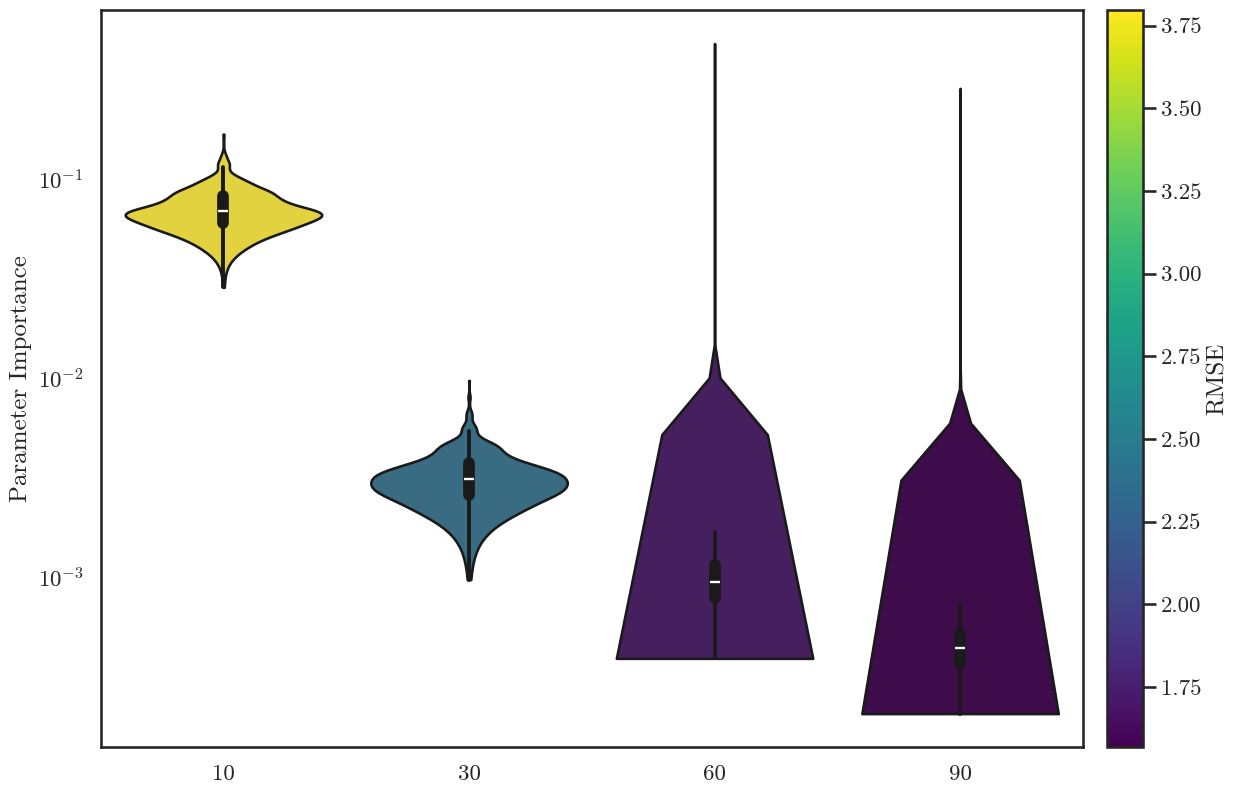

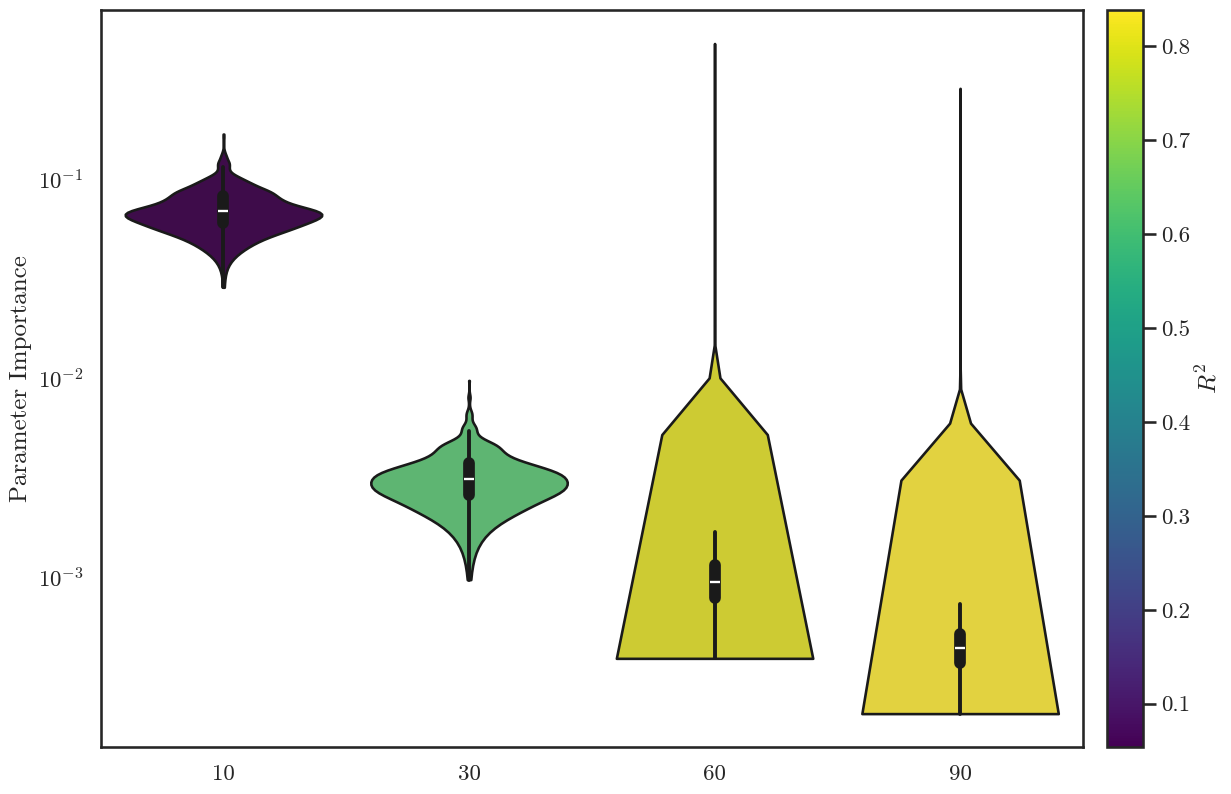

In [257]:
with open('SAS_lengthscales_results.pkl', 'rb') as f:
    results = pickle.load(f)

lengthscales = results['lengthscales']
losses = results['losses']
lossesr2 = results['lossesr2']


counts = [len(ls) for ls in lengthscales]
df = pd.DataFrame({
    'No. Samples': np.repeat(sizes, counts),
    'Parameter Importance': np.array(lengthscales).flatten()**(-2),
})

##########

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=min(losses), vmax=max(losses))
colors = [cmap(norm(loss)) for loss in losses]

order = sizes
plt.figure(figsize=(14,9))
ax = sns.violinplot(
    data=df,
    x='No. Samples',
    y='Parameter Importance',
    order=order,
    palette=colors,
    cut=0
)

ax.set_xlabel("")
ax.set_ylabel("Parameter Importance")

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("RMSE")
plt.yscale('log')
plt.tight_layout()
plt.savefig(f"SAAS_lengthscale_r2.png", dpi=300)
#plt.show()

##########

cmap = plt.cm.viridis
norm = mpl.colors.Normalize(vmin=min(lossesr2), vmax=max(lossesr2))
colors = [cmap(norm(loss)) for loss in lossesr2]

order = sizes
plt.figure(figsize=(14,9))
ax = sns.violinplot(
    data=df,
    x='No. Samples',
    y='Parameter Importance',
    order=order,
    palette=colors,
    cut=0
)

ax.set_xlabel("")
ax.set_ylabel("Parameter Importance")

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"$R^2$")
plt.yscale('log')
plt.tight_layout()
plt.savefig(f"SAAS_lengthscale_r2.png", dpi=300)




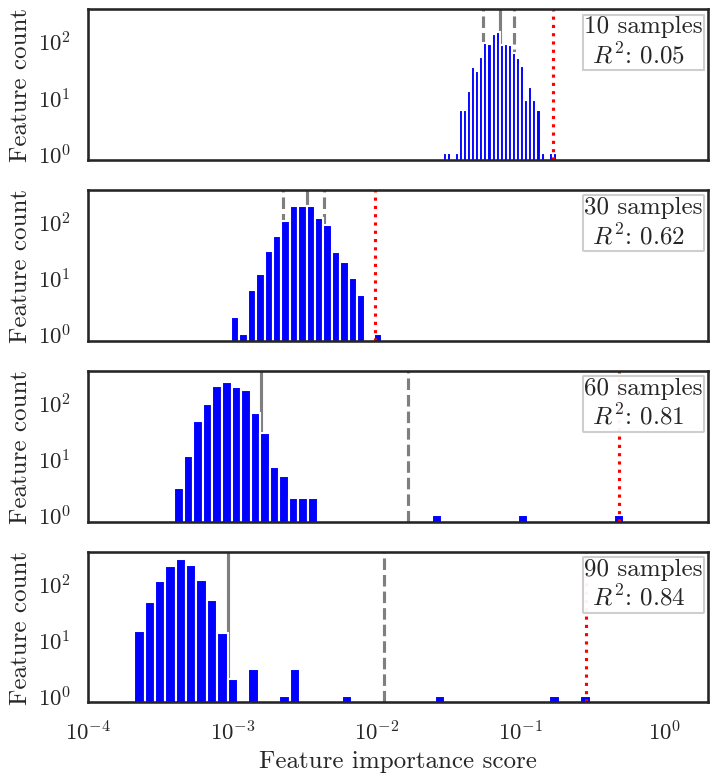

In [281]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
import numpy as np
import matplotlib.text as mtext





font = {'weight' : 'bold',
        'size'   : 330}
plt.rc('font', **font)

class TextOnlyHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        # Create a transparent "dummy" artist
        text = mtext.Text(0, 0, '', fontsize=0)
        return [text]  # Return list with one invisible element

fig, ax = plt.subplots(4, 1, figsize=(8, 9), sharex=True, sharey=True)

for i, L in enumerate(lengthscales):
    Ln = np.array(L)**(-2)
    #bins = np.concatenate([np.linspace(0, 10, 20), np.linspace(10, 60, 100)])
    bins =  np.logspace(np.log10(Ln.min()), np.log10(.7), num=50)

    ax[i].hist(Ln, bins=bins, color='blue')
    ax[i].set_ylabel("Feature count")
    best_bin = np.max(Ln)
    ax[i].axvline(best_bin, color='r', linestyle=':')
    ax[i].axvline(Ln.mean(), color='k', linestyle='-', alpha=.5, zorder=0)
    ax[i].axvline(Ln.mean()+Ln.std(), color='k', linestyle='--', alpha=.5, zorder=0)
    ax[i].axvline(Ln.mean()-Ln.std(), color='k', linestyle='--', alpha=.5, zorder=0)


    # Create legend with text only
    ax[i].legend(
        title=f"{sizes[i]} samples\n $R^2$: {lossesr2[i]:.2f}",
        frameon=True,  # No frame
        handlelength=0,  # No handles
        loc=1,
        fontsize=2,
        framealpha=0.95,
        bbox_to_anchor=(.995, .975),
    )
plt.xlim(1E-4,2)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Feature importance score")
plt.tight_layout()
plt.savefig("SAAS_lengthscales_10_30_60_90.png", dpi=300)

